In [1]:
import pandas as pd

In [276]:

import argparse
import os
import shutil
import numpy as np
import pandas as pd
import numpy as np
import scipy.spatial.distance as ssd
import gc
import h5py
import itertools


def make_tss_tss(gene_data, chrom, dist_folder, RAWobserved, KRnorm, resoulution_in_kb):
    RAWobserved.columns = ["pos1", "pos2", "freq"]
    #normalizing the dataframe as done in the Rao paper
    RAWobserved["pos1_norm"]=RAWobserved["pos1"]/(resoulution_in_kb *1000) 
    RAWobserved["pos2_norm"]=RAWobserved["pos2"]/(resoulution_in_kb *1000)
    RAWobserved["pos1_norm"]=RAWobserved["pos1_norm"].astype(int)
    RAWobserved["pos2_norm"]=RAWobserved["pos2_norm"].astype(int)
    
    RAWobserved_pos1 = RAWobserved.set_index("pos1_norm")
    raw_df = RAWobserved_pos1.merge(right=KRnorm, left_on=RAWobserved_pos1.index, right_on=KRnorm.index, how='left')
    raw_df.drop(['key_0'], inplace=True, axis=1)
    RAWobserved_pos2 = raw_df.set_index("pos2_norm")
    raw_df = RAWobserved_pos2.merge(right=KRnorm, left_on=RAWobserved_pos2.index, right_on=KRnorm.index, how='left')
    raw_df.drop(['key_0'], inplace=True, axis=1)
    raw_df['freq_norm'] = raw_df['freq'] / (raw_df['0_x'] * raw_df['0_y'])
    raw_df.dropna(inplace=True)
    raw_df.reset_index(inplace=True)
    
    del RAWobserved_pos1, RAWobserved_pos2, RAWobserved, KRnorm
    gc.collect()
    
    freq_norm = raw_df['freq_norm'].to_numpy()
    freq_norm_dict = dict(enumerate(freq_norm, 0)) 
    print (freq_norm_dict)
    
    #this step is done to reduce the memmory consumption
    #df_tmp = pd.read_csv("/home/lohia/data/gene_distance_expresseion/georg_paper/MSB-17-7548_Dataset_EV1.csv")
    #GK_genes = df_tmp['Gene_IDs'].to_list()
    #gene_data = gene_data[gene_data['Gene stable ID'].isin(GK_genes)] 
    #gene_data = gene_data[gene_data['Gene type']== 'protein_coding']
    

    tmp_val = []
    gene_occurence_frequency = []
    for tss, tes in zip(gene_data['txStart_outer'].head(10), gene_data['txStart_outer'].head(10)):
        tmpv1 =  (abs(raw_df['pos1']- tss)) <= (resoulution_in_kb *2000)
        tmpv2 =  (abs(raw_df['pos2']- tss)) <= (resoulution_in_kb *2000)
        #tmpv3 =  (abs(raw_df['pos1']- tes)) <= (resoulution_in_kb *2000)
        #tmpv4 =  (abs(raw_df['pos2']- tes)) <= (resoulution_in_kb *2000)
        
        raw_df['BoolCol'] = [x+y for x, y in zip(tmpv1, tmpv2)]
        
        index_list = raw_df.index[raw_df['BoolCol'] > 0].tolist()
        tmp_val.append(index_list)
        gene_occurence_frequency.append(len(tmp_val))
    print (raw_df['BoolCol'])
    #gene_data['gene_occurence_frequency'] = gene_occurence_frequency
    #gene_data.to_csv(os.path.join(dist_folder, f'{chrom}_tss_tss_{resoulution_in_kb}_freq.csv'),
    #                sep=',', columns = ['Gene stable ID', 'gene_occurence_frequency'])
    
    print ("here")
    

    print (([[freq_norm_dict[x] for x in list(set(tmp_val[pairs[0]]).intersection(tmp_val[pairs[1]]))]  for pairs in list(itertools.combinations(range(len(tmp_val)),2))]))
    pairwise_distance = ([np.median([freq_norm_dict[x] for x in list(set(tmp_val[pairs[0]]).intersection(tmp_val[pairs[1]]))]  ) for pairs in list(itertools.combinations(range(len(tmp_val)),2))])
    print (pairwise_distance)
    dist_mat = ssd.squareform(pairwise_distance)
    print (dist_mat)

    
    #dist_mat = ssd.squareform(ssd.pdist(map_hic_tss_bool, lambda u, v: np.median( (freq_norm)[np.nonzero(u*v)] )))
    #dist_mat = ssd.squareform(ssd.pdist(genes_freq, lambda u, v: np.median(np.sqrt( (u * v)[np.nonzero(u*v)] ))))
    #dist_mat = ssd.squareform(ssd.pdist(genes_freq, lambda u, v: np.nanmedian(np.sqrt((u * v)))))

    dist_mat = pd.DataFrame(dist_mat, index=gene_data['Gene stable ID'].head(10),
                            columns=gene_data['Gene stable ID'].head(10))
    dist_mat.fillna(0, inplace=True)
    print (dist_mat)
    
    
    #del dist_mat.index.Gene stable ID
    dist_mat.to_csv(os.path.join(dist_folder, f'{chrom}_tss_tss_{resoulution_in_kb}.csv'),
                    sep=',', float_format='%d')

def make_distance_matrix(gene_folder, dist_folder,resoulution_in_kb=100):
    if os.path.isdir(dist_folder):
   #    shutil.rmtree(dist_folder)
        pass
    else:
        os.mkdir(dist_folder)
    #for subdir in ['tss_tss']:
    #    os.mkdir(os.path.join(dist_folder, subdir))
    for gene_file in os.scandir(gene_folder):
        gene_data = pd.read_csv(gene_file.path, sep='\t',
                                header=0, index_col=None)
        
        if not gene_data.empty:
            print (gene_file.path)
            chrom = gene_data.iloc[0]['chrom']
            #chrom_list = list(range(1,23)) + ['X']
            chrom_list = ['X']
            chrom_list = ['chr%s' %x for x in chrom_list ]
            if chrom in chrom_list:
                prefix = '/'.join(dist_folder.split('/')[:-1])
                RAWobserved = pd.read_csv('%s/GM12878_combined/%skb_resolution_intrachromosomal/%s/MAPQG0/%s_%skb.RAWobserved' %(prefix, resoulution_in_kb, chrom, chrom,resoulution_in_kb),sep='\t', header = None)
                KRnorm = pd.read_csv('%s/GM12878_combined/%skb_resolution_intrachromosomal/%s/MAPQG0/%s_%skb.KRnorm' %(prefix, resoulution_in_kb, chrom, chrom,resoulution_in_kb) ,sep='\t', header = None)
                RAWobserved = RAWobserved.head(10)
                make_tss_tss(gene_data, chrom, dist_folder, RAWobserved, KRnorm, resoulution_in_kb)
            else:
                pass
        else:
           
            pass

In [277]:
make_distance_matrix('/data/lohia/gene_distance_expresseion/gene_tx_map_37', '/data/lohia/gene_distance_expresseion/gene_contact_map_rao/x_t_0_less_way', resoulution_in_kb=10)

/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr10_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr11_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr9_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr12_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr13_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr14_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr15_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr16_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucscgenes_hg37_knowngene_chr4_order.tsv
/data/lohia/gene_distance_expresseion/gene_tx_map_37/gencode32_ucs

/home/lohia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lohia/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [273]:
%%timeit
raw_df = pd.read_csv('/data/lohia/gene_distance_expresseion/gene_contact_map_rao/GM12878_combined/50kb_resolution_intrachromosomal/chrX/MAPQG0/chrX_50kb.RAWobserved' ,sep='\t', header = None)
raw_df.columns = ["pos1", "pos2", "freq_norm"]
freq_norm = raw_df['freq_norm'].to_numpy()
freq_norm_dict = dict(enumerate(freq_norm, 0)) 


#this step is done to reduce the memmory consumption
#df_tmp = pd.read_csv("/home/lohia/data/gene_distance_expresseion/georg_paper/MSB-17-7548_Dataset_EV1.csv")
#GK_genes = df_tmp['Gene_IDs'].to_list()
#gene_data = gene_data[gene_data['Gene stable ID'].isin(GK_genes)] 
#gene_data = gene_data[gene_data['Gene type']== 'protein_coding']


tmp_val = []
gene_occurence_frequency = []
for tss, tes in zip([1,5], [1,5]):
    #pass
    raw_df['tmpv1'] =  (abs(raw_df['pos1']- tss)) <= (10 *2000)
    raw_df['tmpv2'] =  (abs(raw_df['pos2']- tss)) <= (10 *2000)
    tmpv3 =  (abs(raw_df['pos1']- tes)) <= (10 *2000)
    tmpv4 =  (abs(raw_df['pos2']- tes)) <= (10 *2000)

    
    #raw_df['BoolCol'] = raw_df['tmpv1'] + raw_df['tmpv2']
    #print (raw_df['BoolCol'])
    raw_df['BoolCol'] = raw_df[['tmpv1','tmpv2']].sum(axis=1)
    
    
    index_list = raw_df.index[raw_df['pos1'] > 0].tolist()
    tmp_val.append(index_list)


1.7 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [591]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as plticker
from matplotlib.colors import LogNorm


def plots_with_1_level(group_x):

    change_group_level_1 = df_2_or_uniq.groupby(['chrom_x'])
    nrow = int(len(change_group_level_1.groups.keys())/3) + 1
    ncol = 3
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(4*ncol, 4*nrow),sharex=True,sharey=True) 

    for key_level_1,ax in zip(sorted_nicely(change_group_level_1.groups.keys()),axes.flatten()):
        given_group_level_1 = change_group_level_1.get_group(key_level_1)
        #given_group2 = given_group_level_1.groupby(['order_diff', 'category']).mean().groupby(level=2)['exp'].plot(ax=ax)
        given_group2 = given_group_level_1.groupby([group_x]).mean()['exp'].plot(ax=ax)
        given_group2 = given_group_level_1.groupby([group_x]).mean()['exp (GK)'].plot(ax=ax)
        #given_group2 = given_group_level_1.groupby([group_x]).mean()['SRP063477'].plot(ax=ax)
        #given_group2 = given_group_level_1.groupby([group_x]).mean()['SRP026208'].plot(ax=ax)
        #given_group2 = given_group_level_1.groupby([group_x]).mean()['SRP115956'].plot(ax=ax)

        ax.axhline(y=0.5, color='r', linestyle='-')
        #ax.set_xlim([0, 2000])
        ax.legend()
        rects = ax.patches  
        ax.set_title('%s' %(key_level_1))
        #ax.set_ylabel('%Population')
        ax.set_xlabel('Distance between gene pairs (MB)')
        ax.set_ylabel('Co-expression')
        

def plots_with_2_groups(group_2='None', group_3_x='category'):   
    change_group_level_1 = df_2_or_uniq.groupby(['chrom_x'])
    change_group_level_2 = df_2_or_uniq.groupby([group_2])
    nrow = len(change_group_level_1.groups.keys())
    ncol = len(change_group_level_2.groups.keys())
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8*ncol, 8*nrow),sharey=True) 

    for key_level_1,ax_row in zip(sorted_nicely(change_group_level_1.groups.keys()) ,axes):
        given_group_level_1 = change_group_level_1.get_group(key_level_1)
        change_group = given_group_level_1.groupby([group_2])
        for key,ax in zip(change_group.groups.keys(),ax_row):
            given_group = change_group.get_group(key)
            #given_group2 = given_group.groupby([group_3_x, 'category']).mean().groupby(level=1)['exp'].plot(ax=ax)
            given_group2 = given_group.groupby([group_3_x]).mean()['exp'].plot(ax=ax)
            given_group2 = given_group.groupby([group_3_x]).mean()['exp_georg'].plot(ax=ax)
            ax.legend()
            rects = ax.patches  
            ax.set_title('%s, %s' %(key_level_1,key))
            ax.axhline(y=0.5, color='r', linestyle='-')
            ax.set_ylabel('%Population')
            ax.set_ylim([0.3, 0.9])
            
            
def plots_with_2_groups_same_plot(group_2='None', group_3_x='category'):   
    change_group_level_1 = df_2_or_uniq.groupby(['chrom_x'])
    change_group_level_2 = df_2_or_uniq.groupby([group_2])
    nrow = int(len(change_group_level_1.groups.keys())/3) + 1
    ncol = 3
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(4*ncol, 4*nrow),sharey=True, sharex=True) 

    for key_level_1,ax in zip(sorted_nicely(change_group_level_1.groups.keys()) ,axes.flatten()):
        given_group_level_1 = change_group_level_1.get_group(key_level_1)
        change_group = given_group_level_1.groupby([group_2])
        for key in change_group.groups.keys():
            given_group = change_group.get_group(key)
            #given_group2 = given_group.groupby([group_3_x, 'category']).mean().groupby(level=1)['exp'].plot(ax=ax)
            given_group2 = given_group.groupby([group_3_x]).mean()['exp'].plot(ax=ax)
            #given_group2 = given_group.groupby([group_3_x]).mean()['exp_georg'].plot(ax=ax)
            #ax.legend()
            rects = ax.patches  
            ax.set_title('%s, %s' %(key_level_1,key))
            ax.axhline(y=0.5, color='r', linestyle='-')
    ax.set_ylabel('Co-expression')
    ax.set_xlabel('Distance between gene pairs (MB)')
    #ax.set_ylim([0.3, 0.9])
            

def plots_with_1_level_3d(df, group_x):
    change_group_level_1 = df.groupby(['chrom_x'])
    nrow = int(len(change_group_level_1.groups.keys())/3) + 1
    ncol = 3
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(4*ncol, 4*nrow)) 

    for key_level_1,ax in zip(sorted_nicely(change_group_level_1.groups.keys()),axes.flatten()):
            given_group_level_1 = change_group_level_1.get_group(key_level_1)
            H = given_group_level_1.pivot_table(index='gene_order_tss_x', columns='gene_order_tss_y', values=group_x)
            #print (H)
            print ((H - H.T).max().max())
            #H.mask(H < 0, inplace=True)
            #elix.reset_index(drop=True, inplace=True)
            print (H.max())
            vmax= 1
            cmap = LinearSegmentedColormap.from_list('mycmap', [(0/ vmax, 'red'), (1./2, 'white'), (vmax / vmax, 'blue')])
            current_cmap = cmap
            current_cmap.set_bad(color='grey')
            #      vmax= 1000000
            #      current_cmap = LinearSegmentedColormap.from_list('mycmap', [ (0/ vmax, 'white'), (vmax / vmax, 'blue')])
            #      imgp = ax.imshow(H.T,origin='low', aspect='auto' , cmap=current_cmap, norm=LogNorm(vmin=1, vmax=vmax))
            
            imgp = ax.imshow(H,origin='low', aspect='auto' , vmin=0.5, vmax=vmax, cmap=current_cmap)
            #imgp = ax.imshow(H,origin='low', aspect='auto' , norm=LogNorm(), cmap=current_cmap)
            #sns.heatmap(H, annot = False) 
            ax.set_title('%s' %(key_level_1))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xlabel("Genes in chromosome order")
            ax.set_ylabel("Genes in chromosome order")
            
    cbar = ax.figure.colorbar(imgp, ax=ax)

In [516]:
df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/11_dist_with_georg_hic_sub_median_hic_500.h5')

In [499]:
df_2_or = df_2_or[df_2_or['exp_georg'] >= 0] 

In [508]:
df_2_or = df_2_or[df_2_or['hi-c-rao'] >= 0] 

0.0
gene_order_tss_y
6       30508.0
9       30508.0
11      30508.0
12      30508.0
14      30508.0
         ...   
3345    23677.0
3347    23677.0
3348    23677.0
3349    23677.0
3355    78596.0
Length: 1004, dtype: float64


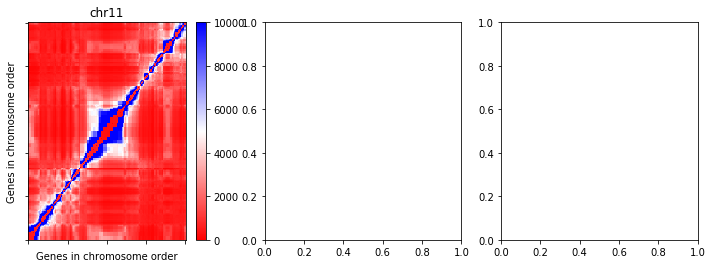

In [504]:
plots_with_1_level_3d(df_2_or, 'hi-c-rao')

0.0
gene_order_tss_y
6       0.999501
9       0.999501
11      0.999501
12      0.999501
14      0.999501
          ...   
3345    0.999501
3347    0.999501
3348    0.999501
3349    0.999501
3355    0.999501
Length: 1004, dtype: float64


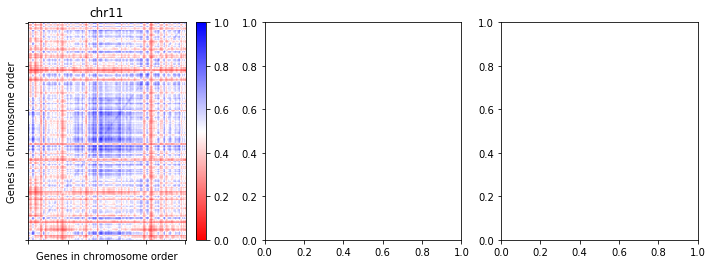

In [513]:
ranked_matirx = rank(df_2_or['exp'])
df_2_or['exp'] = ranked_matirx
plots_with_1_level_3d(df_2_or,'exp')

0.0
gene_order_tss_y
6       0.883556
9       0.883556
11      0.883556
12      0.883556
14      0.883556
          ...   
3345    0.943445
3347    0.943445
3348    0.943445
3349    0.943445
3355    0.943445
Length: 1293, dtype: float64


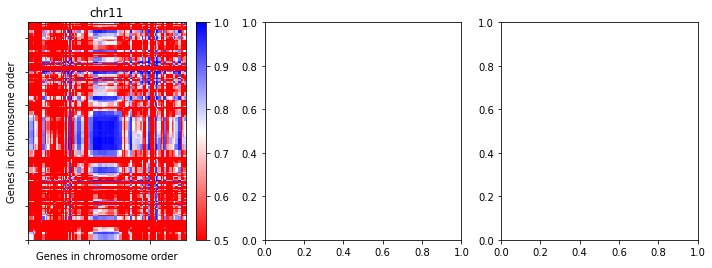

In [592]:
ranked_matirx = rank(df_2_or['exp_median'])
df_2_or['exp_median'] = ranked_matirx
plots_with_1_level_3d(df_2_or,'exp_median')

In [10]:
ranked_matirx = rank(df_2_or_median['exp_median'])
df_2_or_median['exp_median'] = ranked_matirx
plots_with_1_level_3d(df_2_or_median,'exp_median')

NameError: name 'df_2_or_median' is not defined

In [608]:
df_2_or_median = df_2_or

In [ ]:
df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/_dist_with_georg_hic_sub_median_hic_500.h5')

In [382]:
#merges DE prior genes
ensg_gene_name = pd.read_csv("/data/lohia/gene_distance_expresseion/biomart_mapping_files/ENSG_gene_name.txt", sep='\t')
mg_de_prior = pd.read_csv("/data/lohia/gene_distance_expresseion/mc_predictability/pnas.1802973116.sd02.txt", sep='\t')
ensg_gene_name = ensg_gene_name.drop_duplicates('Gene name')
ensg_gene_name_mg_prior = ensg_gene_name.merge(right= mg_de_prior[['Gene_Name','DE_Prior_Rank', 'Gene_Order']], left_on='Gene name', right_on='Gene_Name')

ensg_gene_name_mg_prior.rename(columns={"Gene stable ID": "Gene stable ID_x"}, inplace=True)
df_2_or = df_2_or.merge(right=ensg_gene_name_mg_prior, on='Gene stable ID_x', how='left')
ensg_gene_name_mg_prior.rename(columns={"Gene stable ID_x": "Gene stable ID_y"}, inplace=True)
df_2_or = df_2_or.merge(right=ensg_gene_name_mg_prior, on='Gene stable ID_y', how='left')

In [386]:
df_2_or['DE_tot_rank'] = df_2_or['DE_Prior_Rank_x'] + df_2_or['DE_Prior_Rank_y']

In [520]:
df_2_or

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                      
ENSG00000174669_ENSG00000174669         0  1.000000        NaN       0.0   
ENSG00000174669_ENSG00000183340  30017774  0.863495        NaN     274.0   
ENSG00000174669_ENSG00000182791    220849  0.688515        NaN     401.0   
ENSG00000174669_ENSG00000132275  59768598  0.939615        NaN     404.0   
ENSG00000174669_ENSG00000168496   4579304  0.887136        NaN    4489.0   
...                                   ...       ...        ...       ...   
ENSG00000239306_ENSG00000267940  60413328  0.860745        NaN       NaN   
ENSG00000239306_ENSG00000254694  59592446  0.722093        NaN       NaN   
ENSG00000239306_ENSG00000173715    127869  0.934376        NaN     446.0   
ENSG00000239306_ENSG00000166086  67452489  0.909951        NaN     403.0   
ENSG00000239306_ENSG00000239306         0  1.000000        NaN       0.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000174669_ENSG00000174669        -              1828              1827   
ENSG00000174669_ENSG00000183340        +              2591              2593   
ENSG00000174669_ENSG00000182791        -              1847              1847   
ENSG00000174669_ENSG00000132275        -               384               384   
ENSG00000174669_ENSG00000168496        +              1527              1527   
...                                  ...               ...               ...   
ENSG00000239306_ENSG00000267940        -               366               366   
ENSG00000239306_ENSG00000254694        -              3224              3225   
ENSG00000239306_ENSG00000173715        +              1856              1858   
ENSG00000239306_ENSG00000166086        +              3337              3339   
ENSG00000239306_ENSG00000239306        +              1850              1850   

                                Gene stable ID_x     Gene type_x Uniprot_dc_x  \
pairs                                                                           
ENSG00000174669_ENSG00000174669  ENSG00000174669  protein_coding       Q14542   
ENSG00000174669_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000174669_ENSG00000182791  ENSG00000182791  protein_coding       Q9NVE4   
ENSG00000174669_ENSG00000132275  ENSG00000132275  protein_coding       O43159   
ENSG00000174669_ENSG00000168496  ENSG00000168496  protein_coding       P39748   
...                                          ...             ...          ...   
ENSG00000239306_ENSG00000267940  ENSG00000267940             NaN          NaN   
ENSG00000239306_ENSG00000254694  ENSG00000254694             NaN          NaN   
ENSG00000239306_ENSG00000173715  ENSG00000173715  protein_coding   A0A2U3TZP7   
ENSG00000239306_ENSG00000166086  ENSG00000166086  protein_coding       Q9BX67   
ENSG00000239306_ENSG00000239306  ENSG00000239306  protein_coding       Q96PK6   

                                 ...  chrom_x  strand_y gene_order_tss_y  \
pairs                            ...                                       
ENSG00000174669_ENSG00000174669  ...    chr11         -             1828   
ENSG00000174669_ENSG00000183340  ...    chr11         -             1828   
ENSG00000174669_ENSG00000182791  ...    chr11         -             1828   
ENSG00000174669_ENSG00000132275  ...    chr11         -             1828   
ENSG00000174669_ENSG00000168496  ...    chr11         -             1828   
...                              ...      ...       ...              ...   
ENSG00000239306_ENSG00000267940  ...    chr11         +             1850   
ENSG00000239306_ENSG00000254694  ...    chr11         +             1850   
ENSG00000239306_ENSG00000173715  ...    chr11         +             1850   
ENSG00000239306_ENSG00000166086  ...    chr11         +             1850   
ENSG00000239306_ENSG00000239306  ...  

In [519]:
df_2_or['pairs'] = [x+"_"+y for x,y in zip(df_2_or['Gene stable ID_y'], df_2_or['Gene stable ID_x'])]
df_2_or.set_index('pairs', inplace=True)

In [527]:
df_2_or[(df_2_or['Gene stable ID_x'] == 'ENSG00000174669') & (df_2_or['tss_tss'] <=500000)]

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                     
ENSG00000174669_ENSG00000174669        0  1.000000        NaN       0.0   
ENSG00000182791_ENSG00000174669   220849  0.688515        NaN     401.0   
ENSG00000175592_ENSG00000174669   471641  0.292721        NaN     380.0   
ENSG00000175376_ENSG00000174669   370038  0.938259        NaN     380.0   
ENSG00000174744_ENSG00000174669    27089  0.886680        NaN     401.0   
ENSG00000175229_ENSG00000174669   323053  0.408519        NaN     380.0   
ENSG00000173914_ENSG00000174669   305673  0.955518        NaN     401.0   
ENSG00000172543_ENSG00000174669   492378  0.608773        NaN     380.0   
ENSG00000174903_ENSG00000174669   103625  0.917490        NaN     401.0   
ENSG00000174996_ENSG00000174669   114921  0.964790        NaN     401.0   
ENSG00000174807_ENSG00000174669    55170  0.744971        NaN     401.0   
ENSG00000175115_ENSG00000174669   301943  0.921198        NaN     401.0   
ENSG00000248643_ENSG00000174669   244411  0.698206        NaN     401.0   
ENSG00000175334_ENSG00000174669   369987  0.940329        NaN     380.0   
ENSG00000174165_ENSG00000174669   174021  0.958612        NaN     401.0   
ENSG00000248746_ENSG00000174669   174180  0.511541        NaN     401.0   
ENSG00000175550_ENSG00000174669   452941  0.870073        NaN     380.0   
ENSG00000175602_ENSG00000174669   481542  0.836505        NaN     380.0   
ENSG00000174871_ENSG00000174669    94040  0.730943        NaN     401.0   
ENSG00000255320_ENSG00000174669   125975  0.839466        NaN       NaN   
ENSG00000254986_ENSG00000174669   107798  0.922207        NaN     401.0   
ENSG00000254461_ENSG00000174669   110380  0.851077        NaN       NaN   
ENSG00000245156_ENSG00000174669    93689  0.814795        NaN     401.0   
ENSG00000255468_ENSG00000174669    24265  0.950628        NaN       NaN   
ENSG00000174684_ENSG00000174669    24585  0.954155        NaN     401.0   
ENSG00000173621_ENSG00000174669   484432  0.927786        NaN     446.0   
ENSG00000174791_ENSG00000174669    35374  0.833507        NaN     401.0   
ENSG00000174547_ENSG00000174669    94524  0.922721        NaN     401.0   
ENSG00000173933_ENSG00000174669   266402  0.846646        NaN     401.0   
ENSG00000179292_ENSG00000174669    80321  0.414194        NaN     401.0   
ENSG00000175315_ENSG00000174669   360207  0.374777        NaN     380.0   
ENSG00000174080_ENSG00000174669   196627  0.872283        NaN     401.0   
ENSG00000254510_ENSG00000174669    36943  0.416113        NaN       NaN   
ENSG00000173992_ENSG00000174669   220938  0.940365        NaN     401.0   
ENSG00000175294_ENSG00000174669   345735  0.440095        NaN     380.0   
ENSG00000087365_ENSG00000174669   321486  0.937533        NaN     380.0   
ENSG00000174576_ENSG00000174669    48789  0.231663        NaN     401.0   
ENSG00000172638_ENSG00000174669   498622  0.873684        NaN     380.0   
ENSG00000255517_ENSG00000174669   108019  0.907583        NaN       NaN   
ENSG00000175573_ENSG00000174669   453152  0.928440        NaN     380.0   
ENSG00000173898_ENSG00000174669   357012  0.861919        NaN     401.0   
ENSG00000172500_ENSG00000174669   483675  0.939908        NaN     380.0   
ENSG00000174516_ENSG00000174669    94112  0.945597        NaN     401.0   
ENSG00000174483_ENSG00000174669   138391  0.897050        NaN     401.0   
ENSG00000173653_ENSG00000174669   470620  0.943478        NaN     446.0   
ENSG00000175467_ENSG00000174669   410487  0.929302        NaN     380.0   
ENSG00000174851_ENSG00000174669    83069  0.915673        NaN     401.0   
ENSG00000173715_ENSG00000174669   372236  0.895157        NaN     446.0   
ENSG00000239306_ENSG00000174669   244367  0.962711        NaN     401.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000174669_ENSG00000174669        -       

In [546]:
df_2_or[(df_2_or['Gene stable ID_x'] == 'ENSG00000183340') & (df_2_or['tss_tss'] <=500000)]

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                     
ENSG00000183340_ENSG00000183340        0  1.000000        NaN       0.0   
ENSG00000149231_ENSG00000183340       32  0.996508        NaN     785.0   
ENSG00000184384_ENSG00000183340    46793  0.935457        NaN     785.0   
ENSG00000087053_ENSG00000183340   464673  0.983718        NaN     774.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000183340_ENSG00000183340        +              2591              2593   
ENSG00000149231_ENSG00000183340        +              2591              2593   
ENSG00000184384_ENSG00000183340        +              2591              2593   
ENSG00000087053_ENSG00000183340        +              2591              2593   

                                Gene stable ID_x     Gene type_x Uniprot_dc_x  \
pairs                                                                           
ENSG00000183340_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000149231_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000184384_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000087053_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   

                                 ...  chrom_x  strand_y gene_order_tss_y  \
pairs                            ...                                       
ENSG00000183340_ENSG00000183340  ...    chr11         +             2591   
ENSG00000149231_ENSG00000183340  ...    chr11         -             2590   
ENSG00000184384_ENSG00000183340  ...    chr11         -             2589   
ENSG00000087053_ENSG00000183340  ...    chr11         -             2585   

                                gene_order_tes_y  Gene stable ID_y  \
pairs                                                                
ENSG00000183340_ENSG00000183340             2593   ENSG00000183340   
ENSG00000149231_ENSG00000183340             2590   ENSG00000149231   
ENSG00000184384_ENSG00000183340             2587   ENSG00000184384   
ENSG00000087053_ENSG00000183340             2584   ENSG00000087053   

                                    Gene type_y Uniprot_dc_y      dc_y  \
pairs                                                                    
ENSG00000183340_ENSG00000183340  protein_coding       Q9Y4A0  0.000000   
ENSG00000149231_ENSG00000183340  protein_coding       Q8N4S0  0.540441   
ENSG00000184384_ENSG00000183340  protein_coding       Q8IZL2  0.416955   
ENSG00000087053_ENSG00000183340  protein_coding       Q13614  0.132193   

                                seq_length_y  chrom_y  
pairs                                                  
ENSG00000183340_ENSG00000183340        524.0    chr11  
ENSG00000149231_ENSG00000183340        544.0    chr11  
ENSG00000184384_ENSG00000183340       1156.0    chr11  
ENSG00000087053_ENSG00000183340        643.0    chr11  

[4 rows x 22 columns]

In [543]:
import itertools
y = [r[0]+ '_' + r[1] for r in itertools.product(['ENSG00000183340', 'ENSG00000149231'], ['ENSG00000183340', 'ENSG00000149231'])] 

In [576]:
for r in itertools.product(['ENSG00000183340', 'ENSG00000149231'], ['ENSG00000183340', 'ENSG00000149231']):
                           print (r)
                           print ("v")
        

('ENSG00000183340', 'ENSG00000183340')
v
('ENSG00000183340', 'ENSG00000149231')
v
('ENSG00000149231', 'ENSG00000183340')
v
('ENSG00000149231', 'ENSG00000149231')
v


In [552]:
df_2_or['exp_mean'] = df_2_or.loc[y,:]['exp'].mean()

In [581]:
df_2_or['exp_mean'] = 1

In [582]:
for ind_val in y:
        df_2_or.at[['ENSG00000174669_ENSG00000174669', 'ENSG00000174669_ENSG00000183340'], 'exp_mean'] = df_2_or.loc[y,:]['exp'].mean()

In [583]:
df_2_or

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                      
ENSG00000174669_ENSG00000174669         0  1.000000        NaN       0.0   
ENSG00000174669_ENSG00000183340  30017774  0.863495        NaN     274.0   
ENSG00000174669_ENSG00000182791    220849  0.688515        NaN     401.0   
ENSG00000174669_ENSG00000132275  59768598  0.939615        NaN     404.0   
ENSG00000174669_ENSG00000168496   4579304  0.887136        NaN    4489.0   
...                                   ...       ...        ...       ...   
ENSG00000239306_ENSG00000267940  60413328  0.860745        NaN       NaN   
ENSG00000239306_ENSG00000254694  59592446  0.722093        NaN       NaN   
ENSG00000239306_ENSG00000173715    127869  0.934376        NaN     446.0   
ENSG00000239306_ENSG00000166086  67452489  0.909951        NaN     403.0   
ENSG00000239306_ENSG00000239306         0  1.000000        NaN       0.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000174669_ENSG00000174669        -              1828              1827   
ENSG00000174669_ENSG00000183340        +              2591              2593   
ENSG00000174669_ENSG00000182791        -              1847              1847   
ENSG00000174669_ENSG00000132275        -               384               384   
ENSG00000174669_ENSG00000168496        +              1527              1527   
...                                  ...               ...               ...   
ENSG00000239306_ENSG00000267940        -               366               366   
ENSG00000239306_ENSG00000254694        -              3224              3225   
ENSG00000239306_ENSG00000173715        +              1856              1858   
ENSG00000239306_ENSG00000166086        +              3337              3339   
ENSG00000239306_ENSG00000239306        +              1850              1850   

                                Gene stable ID_x     Gene type_x Uniprot_dc_x  \
pairs                                                                           
ENSG00000174669_ENSG00000174669  ENSG00000174669  protein_coding       Q14542   
ENSG00000174669_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000174669_ENSG00000182791  ENSG00000182791  protein_coding       Q9NVE4   
ENSG00000174669_ENSG00000132275  ENSG00000132275  protein_coding       O43159   
ENSG00000174669_ENSG00000168496  ENSG00000168496  protein_coding       P39748   
...                                          ...             ...          ...   
ENSG00000239306_ENSG00000267940  ENSG00000267940             NaN          NaN   
ENSG00000239306_ENSG00000254694  ENSG00000254694             NaN          NaN   
ENSG00000239306_ENSG00000173715  ENSG00000173715  protein_coding   A0A2U3TZP7   
ENSG00000239306_ENSG00000166086  ENSG00000166086  protein_coding       Q9BX67   
ENSG00000239306_ENSG00000239306  ENSG00000239306  protein_coding       Q96PK6   

                                 ...  strand_y  gene_order_tss_y  \
pairs                            ...                               
ENSG00000174669_ENSG00000174669  ...         -              1828   
ENSG00000174669_ENSG00000183340  ...         -              1828   
ENSG00000174669_ENSG00000182791  ...         -              1828   
ENSG00000174669_ENSG00000132275  ...         -              1828   
ENSG00000174669_ENSG00000168496  ...         -              1828   
...                              ...       ...               ...   
ENSG00000239306_ENSG00000267940  ...         +              1850   
ENSG00000239306_ENSG00000254694  ...         +              1850   
ENSG00000239306_ENSG00000173715  ...         +              1850   
ENSG00000239306_ENSG00000166086  ...         +              1850   
ENSG00000239306_ENSG00000239306  ...         +              1850   

                                gene_order_tes_y Gene stable ID_y

In [557]:
df_2_or['exp_mean'].max()

1.0

In [553]:
df_2_or['exp_mean']

pairs
ENSG00000174669_ENSG00000174669    0.998254
ENSG00000174669_ENSG00000183340    0.998254
ENSG00000174669_ENSG00000182791    0.998254
ENSG00000174669_ENSG00000132275    0.998254
ENSG00000174669_ENSG00000168496    0.998254
                                     ...   
ENSG00000239306_ENSG00000267940    0.998254
ENSG00000239306_ENSG00000254694    0.998254
ENSG00000239306_ENSG00000173715    0.998254
ENSG00000239306_ENSG00000166086    0.998254
ENSG00000239306_ENSG00000239306    0.998254
Name: exp_mean, Length: 1679616, dtype: float64

In [537]:
df_2_or.loc[y,:]['exp']

pairs
ENSG00000183340_ENSG00000174669    0.863495
ENSG00000183340_ENSG00000174483    0.900847
ENSG00000149231_ENSG00000174669    0.784731
ENSG00000149231_ENSG00000174483    0.923430
Name: exp, dtype: float64

In [542]:
unique_genes = list(set(df['Gene stable ID_x'].unique()))

In [549]:
gene_resolution_pairs= {}
for each_gene in  unique_genes:
    gene_resolution_pairs[each_gene] = df_2_or[(df_2_or['Gene stable ID_x'] == each_gene) & (df_2_or['tss_tss'] <=500000)]['Gene stable ID_y'].to_list()

In [604]:
unique_genes[0:10]

['ENSG00000162188',
 'ENSG00000168092',
 'ENSG00000166407',
 'ENSG00000172927',
 'ENSG00000166333',
 'ENSG00000150779',
 'ENSG00000150776',
 'ENSG00000187726',
 'ENSG00000172830',
 'ENSG00000242689']

In [607]:
counter = 0
for pairs in itertools.product(unique_genes, unique_genes):
    counter = counter +1 
    index_list = [r[0]+ '_' + r[1] for r in itertools.product(gene_resolution_pairs[pairs[0]], gene_resolution_pairs[pairs[1]])] 
    if counter == 100000:
        
        print (counter)
    df_2_or.at[index_list, 'exp_mean'] = df_2_or.loc[index_list,:]['exp'].mean()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['ENSG00000250659_ENSG00000250659', 'ENSG00000250659_ENSG00000162222',\n       'ENSG00000250659_ENSG00000204922', 'ENSG00000250659_ENSG00000168569',\n       'ENSG00000250659_ENSG00000162188',\n       ...\n       'ENSG00000185475_ENSG00000269463', 'ENSG00000185475_ENSG00000269176',\n       'ENSG00000185475_ENSG00000255508', 'ENSG00000185475_ENSG00000254454',\n       'ENSG00000185475_ENSG00000252361'],\n      dtype='object', name='pairs', length=408). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [606]:
df_2_or

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                      
ENSG00000174669_ENSG00000174669         0  0.999501        NaN       0.0   
ENSG00000174669_ENSG00000183340  30017774  0.760818        NaN     274.0   
ENSG00000174669_ENSG00000182791    220849  0.542436        NaN     401.0   
ENSG00000174669_ENSG00000132275  59768598  0.886262        NaN     404.0   
ENSG00000174669_ENSG00000168496   4579304  0.797051        NaN    4489.0   
...                                   ...       ...        ...       ...   
ENSG00000239306_ENSG00000151702  62069953  0.809972        NaN     293.0   
ENSG00000239306_ENSG00000156587   9048297  0.789157        NaN    1140.0   
ENSG00000239306_ENSG00000173715    127869  0.876923        NaN     446.0   
ENSG00000239306_ENSG00000166086  67452489  0.834559        NaN     403.0   
ENSG00000239306_ENSG00000239306         0  0.999501        NaN       0.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000174669_ENSG00000174669        -              1828              1827   
ENSG00000174669_ENSG00000183340        +              2591              2593   
ENSG00000174669_ENSG00000182791        -              1847              1847   
ENSG00000174669_ENSG00000132275        -               384               384   
ENSG00000174669_ENSG00000168496        +              1527              1527   
...                                  ...               ...               ...   
ENSG00000239306_ENSG00000151702        +              3260              3262   
ENSG00000239306_ENSG00000156587        -              1336              1336   
ENSG00000239306_ENSG00000173715        +              1856              1858   
ENSG00000239306_ENSG00000166086        +              3337              3339   
ENSG00000239306_ENSG00000239306        +              1850              1850   

                                Gene stable ID_x     Gene type_x Uniprot_dc_x  \
pairs                                                                           
ENSG00000174669_ENSG00000174669  ENSG00000174669  protein_coding       Q14542   
ENSG00000174669_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000174669_ENSG00000182791  ENSG00000182791  protein_coding       Q9NVE4   
ENSG00000174669_ENSG00000132275  ENSG00000132275  protein_coding       O43159   
ENSG00000174669_ENSG00000168496  ENSG00000168496  protein_coding       P39748   
...                                          ...             ...          ...   
ENSG00000239306_ENSG00000151702  ENSG00000151702  protein_coding       Q01543   
ENSG00000239306_ENSG00000156587  ENSG00000156587  protein_coding       O14933   
ENSG00000239306_ENSG00000173715  ENSG00000173715  protein_coding   A0A2U3TZP7   
ENSG00000239306_ENSG00000166086  ENSG00000166086  protein_coding       Q9BX67   
ENSG00000239306_ENSG00000239306  ENSG00000239306  protein_coding       Q96PK6   

                                 ...  gene_order_tss_y  gene_order_tes_y  \
pairs                            ...                                       
ENSG00000174669_ENSG00000174669  ...              1828              1827   
ENSG00000174669_ENSG00000183340  ...              1828              1827   
ENSG00000174669_ENSG00000182791  ...              1828              1827   
ENSG00000174669_ENSG00000132275  ...              1828              1827   
ENSG00000174669_ENSG00000168496  ...              1828              1827   
...                              ...               ...               ...   
ENSG00000239306_ENSG00000151702  ...              1850              1850   
ENSG00000239306_ENSG00000156587  ...              1850              1850   
ENSG00000239306_ENSG00000173715  ...              1850              1850   
ENSG00000239306_ENSG00000166086  ...              1850              1850   
ENSG00000239306_ENSG00000239306  ...  

In [563]:
df_2_or

tss_tss       exp  exp_georg  hi-c-rao  \
pairs                                                                      
ENSG00000174669_ENSG00000174669         0  1.000000        NaN       0.0   
ENSG00000174669_ENSG00000183340  30017774  0.863495        NaN     274.0   
ENSG00000174669_ENSG00000182791    220849  0.688515        NaN     401.0   
ENSG00000174669_ENSG00000132275  59768598  0.939615        NaN     404.0   
ENSG00000174669_ENSG00000168496   4579304  0.887136        NaN    4489.0   
...                                   ...       ...        ...       ...   
ENSG00000239306_ENSG00000267940  60413328  0.860745        NaN       NaN   
ENSG00000239306_ENSG00000254694  59592446  0.722093        NaN       NaN   
ENSG00000239306_ENSG00000173715    127869  0.934376        NaN     446.0   
ENSG00000239306_ENSG00000166086  67452489  0.909951        NaN     403.0   
ENSG00000239306_ENSG00000239306         0  1.000000        NaN       0.0   

                                strand_x  gene_order_tss_x  gene_order_tes_x  \
pairs                                                                          
ENSG00000174669_ENSG00000174669        -              1828              1827   
ENSG00000174669_ENSG00000183340        +              2591              2593   
ENSG00000174669_ENSG00000182791        -              1847              1847   
ENSG00000174669_ENSG00000132275        -               384               384   
ENSG00000174669_ENSG00000168496        +              1527              1527   
...                                  ...               ...               ...   
ENSG00000239306_ENSG00000267940        -               366               366   
ENSG00000239306_ENSG00000254694        -              3224              3225   
ENSG00000239306_ENSG00000173715        +              1856              1858   
ENSG00000239306_ENSG00000166086        +              3337              3339   
ENSG00000239306_ENSG00000239306        +              1850              1850   

                                Gene stable ID_x     Gene type_x Uniprot_dc_x  \
pairs                                                                           
ENSG00000174669_ENSG00000174669  ENSG00000174669  protein_coding       Q14542   
ENSG00000174669_ENSG00000183340  ENSG00000183340  protein_coding       Q9Y4A0   
ENSG00000174669_ENSG00000182791  ENSG00000182791  protein_coding       Q9NVE4   
ENSG00000174669_ENSG00000132275  ENSG00000132275  protein_coding       O43159   
ENSG00000174669_ENSG00000168496  ENSG00000168496  protein_coding       P39748   
...                                          ...             ...          ...   
ENSG00000239306_ENSG00000267940  ENSG00000267940             NaN          NaN   
ENSG00000239306_ENSG00000254694  ENSG00000254694             NaN          NaN   
ENSG00000239306_ENSG00000173715  ENSG00000173715  protein_coding   A0A2U3TZP7   
ENSG00000239306_ENSG00000166086  ENSG00000166086  protein_coding       Q9BX67   
ENSG00000239306_ENSG00000239306  ENSG00000239306  protein_coding       Q96PK6   

                                 ...  strand_y  gene_order_tss_y  \
pairs                            ...                               
ENSG00000174669_ENSG00000174669  ...         -              1828   
ENSG00000174669_ENSG00000183340  ...         -              1828   
ENSG00000174669_ENSG00000182791  ...         -              1828   
ENSG00000174669_ENSG00000132275  ...         -              1828   
ENSG00000174669_ENSG00000168496  ...         -              1828   
...                              ...       ...               ...   
ENSG00000239306_ENSG00000267940  ...         +              1850   
ENSG00000239306_ENSG00000254694  ...         +              1850   
ENSG00000239306_ENSG00000173715  ...         +              1850   
ENSG00000239306_ENSG00000166086  ...         +              1850   
ENSG00000239306_ENSG00000239306  ...         +              1850   

                                gene_order_tes_y Gene stable ID_y

In [ ]:
for r in itertools.product(unique_genes, unique_genes):

In [385]:
np.float('nan') + 3

nan

In [319]:
df_2_or = df_2_or[df_2_or['exp_georg'] >= 0] # liming the matrix to only chosen values for rank standerization

In [321]:
df_2_or_u = df_2_or[df_2_or['Gene stable ID_x'] != df_2_or['Gene stable ID_y']]

In [322]:
df_2_or_u['hi-c-rao'].isnull().astype(int).sum() / df_2_or_u.shape[0]

0.5989310739310739

In [189]:
h = df_2_or_uf.groupby(['hi-c-rao']).count()

(0, 500)

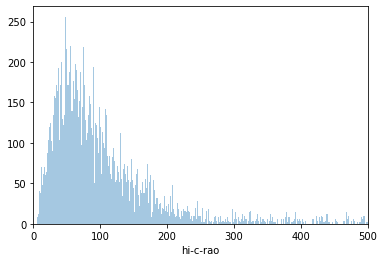

In [275]:
import seaborn as sns
ax = sns.distplot(df_2_or_u['hi-c-rao'], bins=10000, hist=True, kde=False, hist_kws={"range":(1, 10000)})
#ax.set_ylim(0, 500)
ax.set_xlim(0, 500)

In [262]:
df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/11_dist_with_georg_hic_sub_median_hic_500.h5')

In [136]:
df_2_or_u

tss_tss       exp  exp_georg  hi-c-rao strand_x  gene_order_tss_x  \
342895   105160442  0.950081   0.051895     119.0        -                76   
343297   105838535  0.980966   0.774490     119.0        +                15   
1275528  105328086  0.856056   0.106404     119.0        +              2699   
343381   105232971  0.889197   0.070446     119.0        -                73   
343326   105867990  0.981978   0.226579     119.0        +                12   
...            ...       ...        ...       ...      ...               ...   
355214     1066522  0.936410   0.991767   47941.0        +               146   
469661     1090177  0.993863   0.884164   53696.0        +               509   
470153     1032482  0.994699   0.938420   53696.0        -               511   
1297658    1032482  0.994699   0.938420   53696.0        +               530   
660026     1090177  0.993863   0.884164   53696.0        +               530   

         gene_order_tes_x Gene stable ID_x     Gene type_x Uniprot_dc_x  ...  \
342895                 76  ENSG00000177830  protein_coding       Q9BWS9  ...   
343297                 16  ENSG00000185627  protein_coding   A0A087WUL9  ...   
1275528              2701  ENSG00000149313  protein_coding       Q9NRN7  ...   
343381                 72  ENSG00000177700  protein_coding       P62875  ...   
343326                 14  ENSG00000177963  protein_coding       Q9NPQ8  ...   
...                   ...              ...             ...          ...  ...   
355214                147  ENSG00000110651  protein_coding       A6NMH8  ...   
469661                511  ENSG00000198730  protein_coding       Q6PD62  ...   
470153                509  ENSG00000110321  protein_coding       D3DQV9  ...   
1297658               532  ENSG00000170242  protein_coding       Q96K76  ...   
660026                532  ENSG00000170242  protein_coding       Q96K76  ...   

         chrom_x  strand_y gene_order_tss_y gene_order_tes_y  \
342895     chr11         +             2699             2701   
343297     chr11         +             2699             2701   
1275528    chr11         +               59               59   
343381     chr11         +             2699             2701   
343326     chr11         +             2699             2701   
...          ...       ...              ...              ...   
355214     chr11         -               87               87   
469661     chr11         +              530              532   
470153     chr11         +              530              532   
1297658    chr11         -              511              509   
660026     chr11         +              509              511   

         Gene stable ID_y     Gene type_y Uniprot_dc_y      dc_y seq_length_y  \
342895    ENSG00000149313  protein_coding       Q9NRN7  0.000000        309.0   
343297    ENSG00000149313  protein_coding       Q9NRN7  0.000000        309.0   
1275528   ENSG00000177156  protein_coding       P37837  0.000000        337.0   
343381    ENSG00000149313  protein_coding       Q9NRN7  0.000000        309.0   
343326    ENSG00000149313  protein_coding       Q9NRN7  0.000000        309.0   
...                   ...             ...          ...       ...          ...   
355214    ENSG00000078902  protein_coding       Q9H0E2  0.000000        274.0   
469661    ENSG00000170242  protein_coding       Q96K76  0.130182       1375.0   
470153    ENSG00000170242  protein_coding       Q96K76  0.130182       1375.0   
1297658   ENSG00000110321  protein_coding       D3DQV9  0.126792        907.0   
660026    ENSG00000198730  protein_coding       Q6PD62  0.240409       1173.0   

         chrom_y  
342895     chr11  
343297     chr11  
1275528    chr11  
343381     chr11  
343326     chr11  
...          ...  
355214     chr11  
469661     chr11  
470153     chr11  
1297658    chr11  
660026     chr11  

[59780 rows x 22 columns]

In [127]:
df_2_or_u = df_2_or_u.sort_values(by=['hi-c-rao'], ascending=True) 

In [137]:
for i in df_2_or_u.index.values[0:2]:
    print (i)
    long_form_top.at[i]=-1

342895
343297


In [8]:
# import numpy as np
import pandas as pd
import warnings
from lohia_utilities.calculate_auc import *
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from lohia_utilities.create_corr_network import rank

df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/combined_dist_with_georg_hic_sub_median_hic_250.h5')

#df_2_or = df_2_or[df_2_or['exp_georg'] >= 0] # liming the matrix to only chosen values for rank standerization
df_2_or = df_2_or[df_2_or['hi-c-rao'] >= 0] # liming the matrix to only chosen values for rank standerization
df_2_or_u = df_2_or[df_2_or['Gene stable ID_x'] != df_2_or['Gene stable ID_y']]
#ranked_matirx = rank(df_2_or['exp_georg'])
#df_2_or['exp_georg'] = ranked_matirx
#df_2_or.rename(columns={"exp_georg": "exp (GK)"}, inplace=True)

ranked_matirx = rank(df_2_or['exp'])
df_2_or['exp'] = ranked_matirx

#ranked_matirx = rank(df_2_or['hi-c-rao'])
#df_2_or['hi-c-rao'] = ranked_matirx
m_l = []
change_group_level_1 = df_2_or.groupby(['chrom_x'])
for chrm in change_group_level_1.groups.keys():
    df = change_group_level_1.get_group(chrm)
    num_pairs = df['Gene stable ID_x'].nunique()

    prot_list_sp = np.array_split(df, num_pairs, axis=0)
    for i in range(0,num_pairs):

        long_form_top = prot_list_sp[int(i)]
        long_form_top['dist'] = long_form_top['hi-c-rao']
        long_form_top = long_form_top[long_form_top['tss_tss'] >= 10000000] # liming the matrix to only chosen values for rank standerization

        long_form_top = long_form_top[long_form_top['Gene stable ID_x'] != long_form_top['Gene stable ID_y']] # remove all the self pairs from each set
        long_form_top['hi-c-rao'].fillna(-1, inplace=True)
        mp =  long_form_top['Gene stable ID_y'].values[0]
        #print (long_form_top.shape)
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()

        long_form_top = long_form_top.reset_index()
        if long_form_top['exp'].values[0] >=0:
    
       

            for dist_thresh in [1,5,10,100,int(num_pairs/2)]:
            #for dist_thresh in [100000,1000000,10000000,100000000]:
            #for dist_thresh in [4000]:
            #for dist_thresh in [df_2_or_u["hi-c-rao"].min(), df_2_or["hi-c-rao"].max()-1, df_2_or["hi-c-rao"].mean(), df_2_or["hi-c-rao"].median()]:
                #long_form_top["True_sim"] = [1 if score > dist_thresh else 0 for score in long_form_top["dist"]]  
                
                #long_form_top = long_form_top.sort_values(by=['dist'], ascending=False) 
                #long_form_top["True_sim"] = [0 if score > dist_thresh else 0 for score in long_form_top["dist"]]  
                #for ind_val in long_form_top.index.values[0:dist_thresh]:
                #    long_form_top.at[ind_val, 'True_sim'] = 1
                    
                long_form_top = long_form_top.sort_values(by=['dist'], ascending=True) 
                long_form_top["True_sim"] = [1 if score > dist_thresh else 1 for score in long_form_top["dist"]]  
                for ind_val in long_form_top.index.values[0:dist_thresh]:
                    long_form_top.at[ind_val, 'True_sim'] = 0
                #
                #long_form_top["True_sim"] = [1 if score <= dist_thresh else 0 for score in long_form_top["dist"]] 
                #long_form_top["True_sim"] = [1 if score >= dist_thresh else 1 if score2 <= 1000 else 0 for score, score2 in zip(long_form_top["dist"],long_form_top["tss_tss"])]    
                long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
                long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
                long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp"]]
                ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
                m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
                pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

                tpd = pd.DataFrame(m_curve)
                if m_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    m_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    m_curve  = {}
                tpd = pd.DataFrame(pr_curve)
                if pr_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    pr_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    pr_curve  = {}
                m_l.append((chrm, num_pairs,dist_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), exp_median, exp_mean, exp_var, mp))
        else:
            pass

df_scores = pd.DataFrame(m_l, columns =['chrm', 'num_pairs','dist_thresh',  'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'exp_median', 'exp_mean', 'exp_var', 'Gene stable ID'])
df_scores.to_hdf('/data/lohia/gene_distance_expresseion/dist_files/combined_250kb_tn.h5', key='df', mode='w')    

/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['chrm', 'plot', 'pr_curve', 'Gene stable ID'], dtype='object')]

  encoding=encoding,


In [11]:
df_scores = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/combined_250kb_tn.h5')

In [493]:
df_scores

chrm  num_pairs  dist_thresh       auc  \
0     chr11       1004         4000       NaN   
1     chr11       1004         4000       NaN   
2     chr11       1004         4000       NaN   
3     chr11       1004         4000       NaN   
4     chr11       1004         4000  0.561063   
...     ...        ...          ...       ...   
999   chr11       1004         4000       NaN   
1000  chr11       1004         4000  0.820235   
1001  chr11       1004         4000       NaN   
1002  chr11       1004         4000  0.427163   
1003  chr11       1004         4000       NaN   

                                                   plot  \
0     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
2     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
3     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
4     {0.0: 0.0, 0.01: 0.0, 0.02: 0.0104166666666666...   
...                                                 ...   
999   {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1000  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1001  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1002  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.01739...   
1003  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   

                                               pr_curve  true_pos  true_neg  \
0                                                    {}         0       650   
1                                                    {}         0       932   
2                                                    {}         0       647   
3                                                    {}         0       828   
4     {0.0: 0.0, 0.08: 0.021899579772188874, 0.17: 0...        12       696   
...                                                 ...       ...       ...   
999                                                  {}         0       896   
1000  {0.0: 0.0, 0.33: 0.011573465587966434, 0.67: 0...         3       738   
1001                                                 {}         0       646   
1002  {0.0: 0.0, 0.04: 0.03137291143578475, 0.09: 0....        23       913   
1003                                                 {}         0       647   

      exp_median  exp_mean   exp_var   Gene stable ID  
0       0.592583  0.547375  0.063044  ENSG00000174669  
1       0.732026  0.656574  0.070272  ENSG00000183340  
2       0.392391  0.379631  0.036577  ENSG00000182791  
3       0.822697  0.728352  0.067169  ENSG00000132275  
4       0.650224  0.608971  0.084299  ENSG00000168496  
...          ...       ...       ...              ...  
999     0.710174  0.617268  0.067416  ENSG00000151702  
1000    0.580503  0.522850  0.076284  ENSG00000156587  
1001    0.653405  0.605870  0.066594  ENSG00000173715  
1002    0.657461  0.592015  0.051981  ENSG00000166086  
1003    0.728689  0.649545  0.071352  ENSG00000239306  

[1004 rows x 12 columns]

In [12]:
df_scores = df_scores[df_scores['dist_thresh'] <= 100]
df_scores = df_scores[df_scores['dist_thresh'] != 89]
df_scores = df_scores.rename(columns={"dist_thresh": "#of TN"})

In [595]:
df_scores[df_scores['dist_thresh'] == 4000]['auc'].isnull().astype(int).sum()

803

In [220]:
df_scores[df_scores['dist_thresh'] == 2000]

chrm  num_pairs  dist_thresh  auc  \
4     chr16        773         2000  NaN   
9     chr16        773         2000  NaN   
14    chr16        773         2000  NaN   
19    chr16        773         2000  NaN   
24    chr16        773         2000  NaN   
...     ...        ...          ...  ...   
3844  chr16        773         2000  NaN   
3849  chr16        773         2000  NaN   
3854  chr16        773         2000  NaN   
3859  chr16        773         2000  NaN   
3864  chr16        773         2000  NaN   

                                                   plot pr_curve  true_pos  \
4     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
9     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
14    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
19    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
24    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
...                                                 ...      ...       ...   
3844  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3849  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3854  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3859  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3864  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   

      true_neg  exp_median  exp_mean   exp_var   Gene stable ID  
4          495    0.345003  0.322651  0.030117  ENSG00000245694  
9          496    0.619299  0.585025  0.087750  ENSG00000245694  
14         437    0.486055  0.477094  0.069154  ENSG00000198931  
19         420    0.554352  0.556762  0.077769  ENSG00000243716  
24         428    0.828832  0.726001  0.064853  ENSG00000168434  
...        ...         ...       ...       ...              ...  
3844       428    0.425241  0.405120  0.049482  ENSG00000260807  
3849       432    0.490119  0.454270  0.064232  ENSG00000169627  
3854       442    0.474922  0.465165  0.052825  ENSG00000248124  
3859       494    0.360949  0.368468  0.032043  ENSG00000102935  
3864       495    0.572479  0.551079  0.061528  ENSG00000177200  

[773 rows x 12 columns]

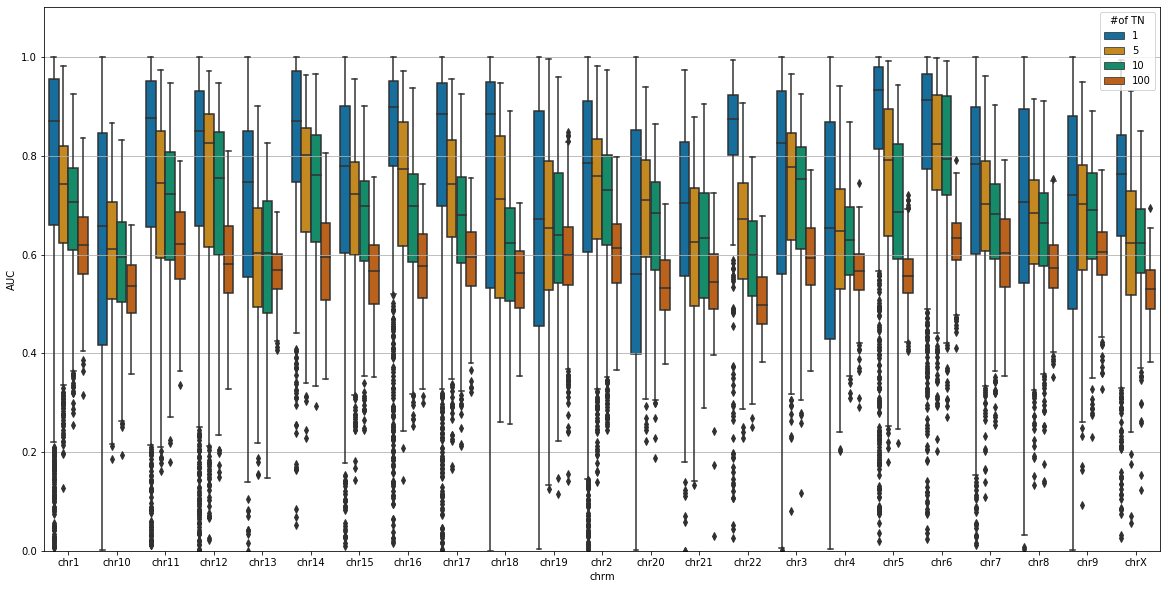

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='#of TN'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

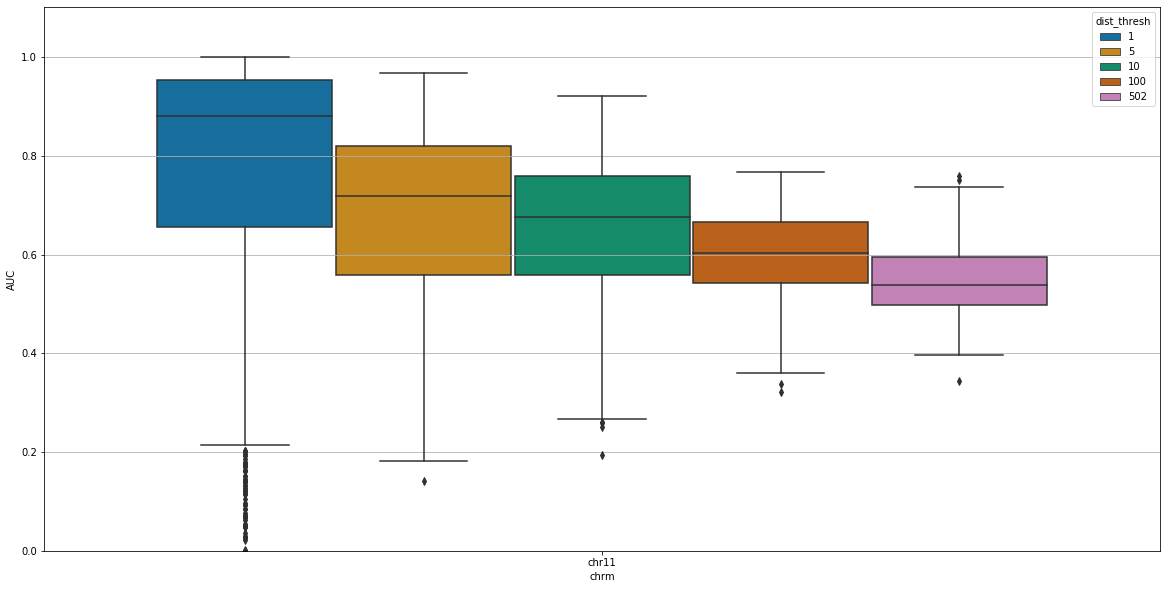

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

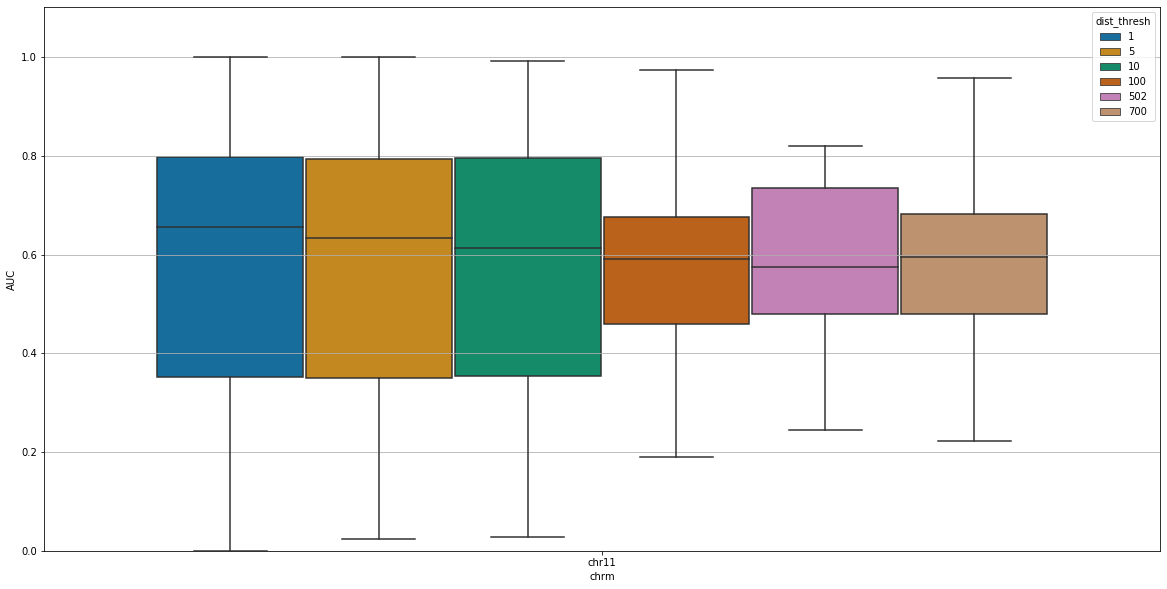

In [602]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

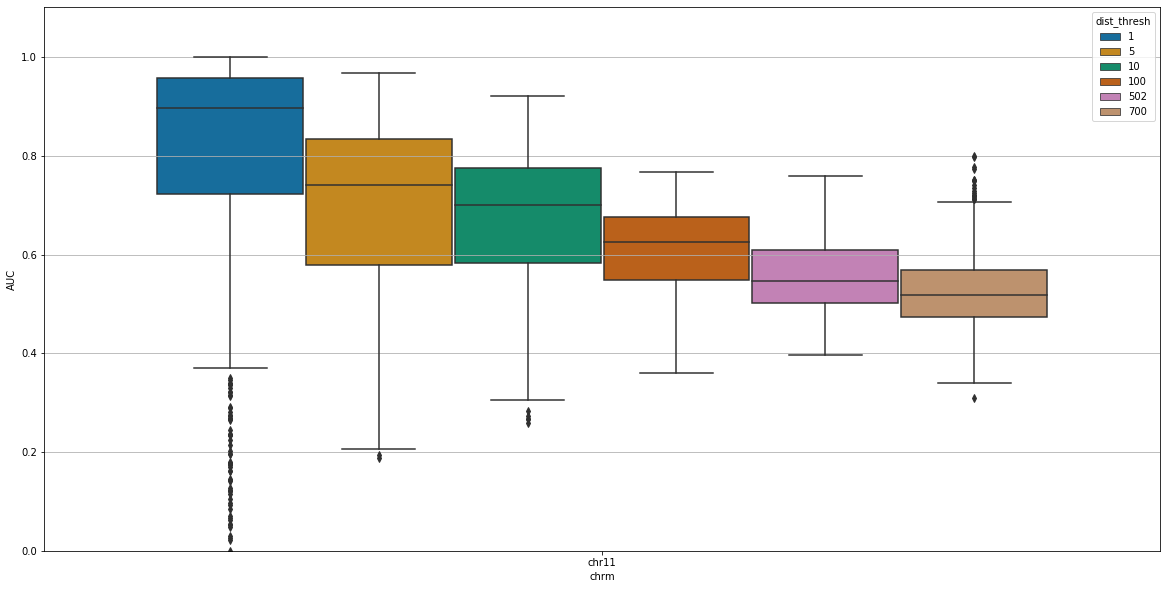

In [414]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [149]:
df_scores_plot = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)
df_plot = df_scores_plot.groupby(['chrm']).median()

In [143]:
df_scores['plot']

0       {0.0: 0.15891472868217105, 0.1: 0.358914728682...
1       {0.0: 0.19172932330827042, 0.1: 0.479591836734...
2       {0.0: 0.027435610302351626, 0.1: 0.14389697648...
3       {0.0: 0.03850267379679142, 0.1: 0.107486631016...
4       {0.0: 0.3575498575498566, 0.1: 0.7236467236467...
                              ...                        
999     {0.0: 0.0858757062146893, 0.1: 0.3598870056497...
1000    {0.0: 0.09021739130434761, 0.1: 0.192391304347...
1001    {0.0: 0.03621346886912323, 0.1: 0.156289707750...
1002    {0.0: 0.09125188536953226, 0.1: 0.208898944193...
1003    {0.0: 0.06352459016393448, 0.1: 0.174863387978...
Name: plot, Length: 1004, dtype: object

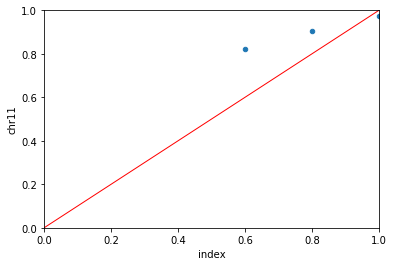

In [150]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[11::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

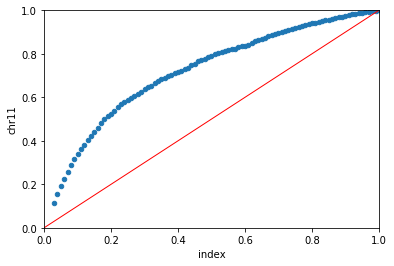

In [258]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[11::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [154]:
df_scores_plot

chrm  num_pairs  dist_thresh       auc  \
0     chr11       1004          2.0  0.603357   
1     chr11       1004          1.0  0.950000   
2     chr11       1004          1.0  0.990826   
3     chr11       1004          2.0  0.964930   
4     chr11       1004          5.0  0.937400   
...     ...        ...          ...       ...   
999   chr11       1004          2.0  0.074297   
1000  chr11       1004          6.0  0.426445   
1001  chr11       1004          6.0  0.650485   
1002  chr11       1004          6.0  0.793478   
1003  chr11       1004          6.0  0.855932   

                                               pr_curve  true_pos  true_neg  \
0     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       566         2   
1     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       480         1   
2     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       436         1   
3     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       499         2   
4     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       623         2   
...                                                 ...       ...       ...   
999   {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       498         1   
1000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       571         2   
1001  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       618         1   
1002  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       552         3   
1003  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       472         1   

      exp_median  exp_mean   exp_var  ... 0.82  0.83  0.85  0.86  0.88  0.89  \
0       0.818331  0.709948  0.077252  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1       0.711796  0.638367  0.072380  ...  NaN   NaN   NaN   NaN   NaN   NaN   
2       0.680995  0.613632  0.075320  ...  NaN   NaN   NaN   NaN   NaN   NaN   
3       0.690213  0.630627  0.070869  ...  NaN   NaN   NaN   NaN   NaN   NaN   
4       0.712888  0.625489  0.079132  ...  NaN   NaN   NaN   NaN   NaN   NaN   
...          ...       ...       ...  ...  ...   ...   ...   ...   ...   ...   
999     0.061497  0.109356  0.028743  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1000    0.264574  0.274264  0.040111  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1001    0.480949  0.495839  0.064536  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1002    0.684659  0.632675  0.075314  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1003    0.745523  0.660855  0.078882  ...  NaN   NaN   NaN   NaN   NaN   NaN   

      0.9  0.91  0.92       1.0  
0     NaN   NaN   NaN  0.863074  
1     NaN   NaN   NaN  0.975000  
2     NaN   NaN   NaN  0.995413  
3     NaN   NaN   NaN  0.994990  
4     NaN   NaN   NaN  0.981541  
...   ...   ...   ...       ...  
999   NaN   NaN   NaN  0.537149  
1000  NaN   NaN   NaN  0.834501  
1001  NaN   NaN   NaN  0.825243  
1002  NaN   NaN   NaN  0.987319  
1003  NaN   NaN   NaN  0.927966  

[1004 rows x 66 columns]

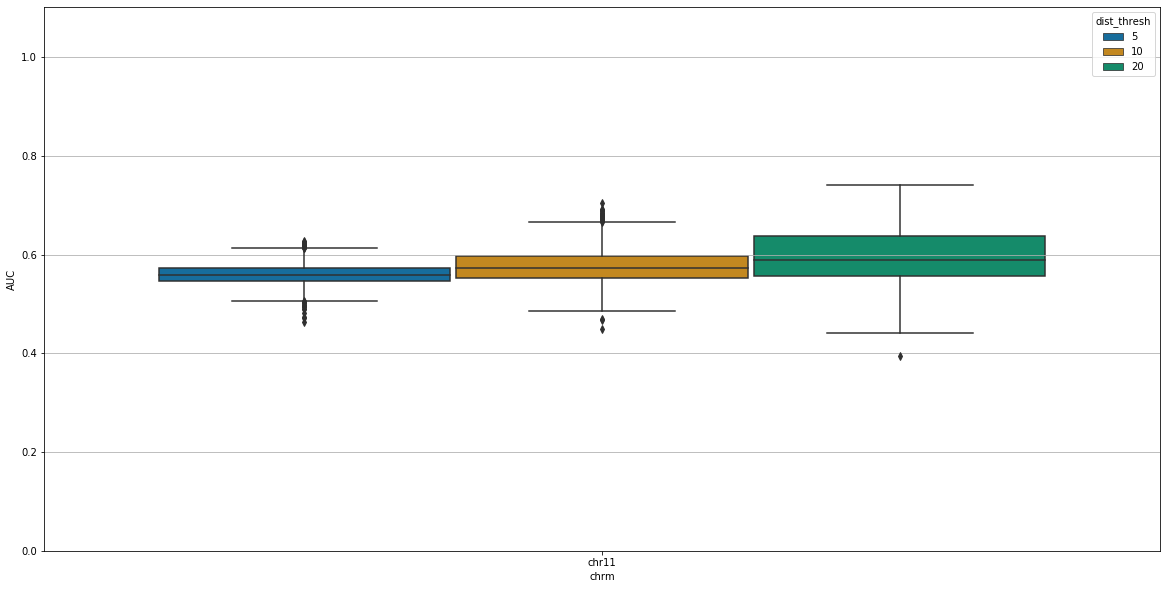

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind",
                 hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()